In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d pcbreviglieri/pneumonia-xray-images

100% 1.14G/1.14G [00:12<00:00, 131MB/s]
100% 1.14G/1.14G [00:12<00:00, 99.5MB/s]


In [ ]:
import zipfile
zf = "/content/pneumonia-xray-images.zip"
target_dir = "/content/dataset/cnn/pneumonia_revamped"
zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
!pip install efficientnet

     |████████████████████████████████| 51kB 4.1MB/s 


In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD

from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

import gdown
import zipfile

import os
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import model_selection

from collections import Counter

import keras
from keras.models import Sequential
from keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape, Dense, Conv2D, GlobalAveragePooling2D

import keras.optimizers as optimizers
from keras.callbacks import ModelCheckpoint

import efficientnet.keras as enet

from imgaug import augmenters

In [ ]:
train_path = '/content/dataset/cnn/pneumonia_revamped/train'
test_path = '/content/dataset/cnn/pneumonia_revamped/test'
valid_path = '/content/dataset/cnn/pneumonia_revamped/val'

In [ ]:
batch_size = 32

img_height = 75
img_width = 75

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
image_gen = ImageDataGenerator(rescale=1./255,zoom_range=0.2,shear_range=0.2,horizontal_flip=True)
test_data_gen = ImageDataGenerator(rescale=1./255)

In [ ]:
train = image_gen.flow_from_directory(train_path,target_size=(img_height,img_width),class_mode='binary',batch_size=batch_size)
test = test_data_gen.flow_from_directory(test_path,target_size=(img_height,img_width),shuffle=False,class_mode='binary',batch_size=batch_size)
valid = test_data_gen.flow_from_directory(valid_path,target_size=(img_height,img_width),class_mode='binary',batch_size=batch_size)

Found 4192 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 1040 images belonging to 2 classes.


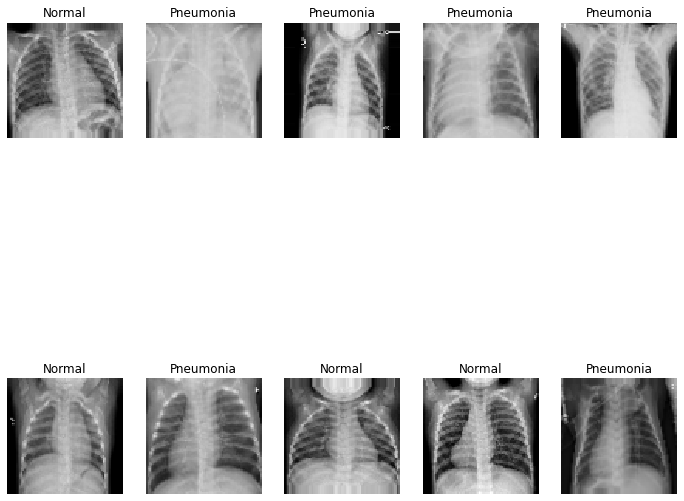

In [ ]:
plt.figure(figsize=(12,12))
for i in range(0,10):
  plt.subplot(2,5,i+1)
  for X_batch,Y_batch in train:
    image = X_batch[0]
    dic = {0:'Normal',1:'Pneumonia'}
    plt.title(dic.get(Y_batch[0]))
    plt.axis('off')

    plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
    break

    plt.tight_layout()
    plt.show()

In [ ]:
expert_conv = enet.EfficientNetB5(include_top=False, input_shape=(img_width,img_height,3), weights='imagenet')

for layer in expert_conv.layers:
      trainable = True
      layer.trainable = trainable


expert_model = Sequential()
# expert_model.add(Reshape((64,64,3)))
expert_model.add(expert_conv)
expert_model.add(GlobalAveragePooling2D())

expert_model.add(Dense(128, activation = 'relu'))
expert_model.add(Dropout(0.3))
expert_model.add(Dense(64, activation = 'relu'))
expert_model.add(Dense(1, activation = "sigmoid"))

opt = keras.optimizers.SGD(lr=1e-4, momentum=0.95)

expert_model.compile(loss = "binary_crossentropy", optimizer = opt, metrics=['accuracy'])

In [ ]:
expert_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b5 (Functional) (None, 3, 3, 2048)        28513520  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 28,784,113
Trainable params: 28,611,377
Non-trainable params: 172,736
____________________________________

In [ ]:
early = EarlyStopping(monitor="val_loss",mode="min",patience=3)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',patience=2,verbose=1,factor=0.3,min_lr=0.000001)
callbacks_list = [early,learning_rate_reduction]

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced',np.unique(train.classes),train.classes)
cw = dict(zip(np.unique(train.classes),weights))
print(cw)

{0: 1.9371534195933457, 1: 0.6739549839228296}


In [24]:
expert_model.fit(train,epochs=25,validation_data=valid,class_weight=cw,batch_size=512)

Epoch 1/25
131/131 [==============================] - 745s 6s/step - loss: 0.7055 - accuracy: 0.4098 - val_loss: 0.7125 - val_accuracy: 0.4635
Epoch 2/25
131/131 [==============================] - 719s 5s/step - loss: 0.6886 - accuracy: 0.4835 - val_loss: 0.7075 - val_accuracy: 0.4894
Epoch 3/25
131/131 [==============================] - 718s 5s/step - loss: 0.6621 - accuracy: 0.5841 - val_loss: 0.6766 - val_accuracy: 0.5750
Epoch 4/25
131/131 [==============================] - 719s 5s/step - loss: 0.6457 - accuracy: 0.6276 - val_loss: 0.6656 - val_accuracy: 0.6029
Epoch 5/25
131/131 [==============================] - 719s 5s/step - loss: 0.6114 - accuracy: 0.6798 - val_loss: 0.6347 - val_accuracy: 0.6798
Epoch 6/25
131/131 [==============================] - 719s 5s/step - loss: 0.5922 - accuracy: 0.7315 - val_loss: 0.5964 - val_accuracy: 0.7337
Epoch 7/25
131/131 [==============================] - 719s 5s/step - loss: 0.5628 - accuracy: 0.7553 - val_loss: 0.5729 - val_accuracy: 0.7596

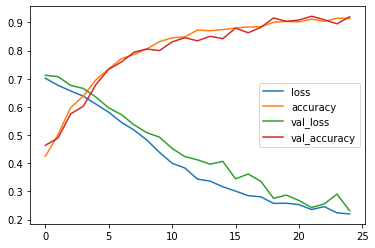

In [25]:
pd.DataFrame(expert_model.history.history).plot()

In [26]:
test_accu = expert_model.evaluate(test)
print('The testing accuracy is - ',test_accu[1]*100,'%')

20/20 [==============================] - 19s 910ms/step - loss: 0.2855 - accuracy: 0.8862
The testing accuracy is -  88.62179517745972 %


In [27]:
from sklearn.metrics import accuracy_score,roc_auc_score,f1_score, log_loss

In [28]:
y_bar = np.round(expert_model.predict(test)).reshape(-1)
y_act = test.labels

In [29]:
##accuracy
print("Accuracy: ",accuracy_score(y_bar,y_act))
##Roc_Auc Score
print("ROC-AUC score: ",roc_auc_score(y_bar,y_act))
##F1-Score Score
print("F1 score: ",f1_score(y_bar,y_act))
##Log Loss Score
print("Log Loss: ",log_loss(y_bar,y_act))

Accuracy:  0.8862179487179487
ROC-AUC score:  0.8809857978279031
F1 score:  0.9100126742712294
Log Loss:  3.929932550575313
